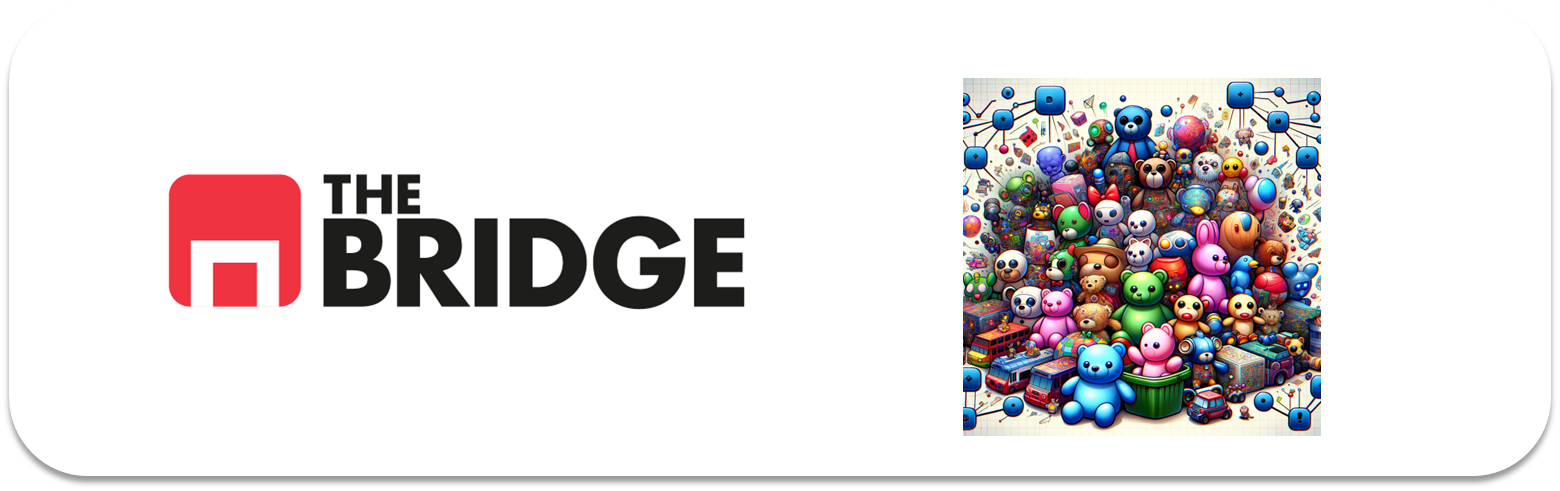

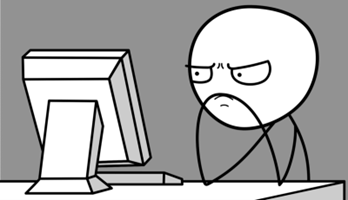

## PRACTICA OBLIGATORIA: K-MEANS

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

seed = 22

## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferen
tes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [2]:
# Cargar el conjunto de datos Olivetti Faces
dataset = fetch_olivetti_faces()

# Mostrar la descripción del dataset
print(dataset['DESCR'])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [3]:
# Crear un DataFrame con las imágenes y sus etiquetas
df = pd.DataFrame(dataset['data'])
df['target'] = dataset['target']

# Reordenar aleatoriamente las filas del DataFrame
df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# Separar las características (X) y las etiquetas (y)
X = df_shuffled.drop(columns='target')
y = df_shuffled['target']

### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [4]:
# Primera división: 90% para train_temp y 10% para test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=seed
)

# Segunda división: 88.89% para train y 11.11% para validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_temp, y_train_temp, test_size=0.1111, stratify=y_train_temp, random_state=seed
)

# Verificar las proporciones
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)} (~80%)")
print(f"Tamaño del conjunto de validación: {len(X_valid)} (~10%)")
print(f"Tamaño del conjunto de prueba: {len(X_test)} (~10%)")

Tamaño del conjunto de entrenamiento: 320 (~80%)
Tamaño del conjunto de validación: 40 (~10%)
Tamaño del conjunto de prueba: 40 (~10%)


### #1.4

Crea los pares X,y para train, validation y test.

Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

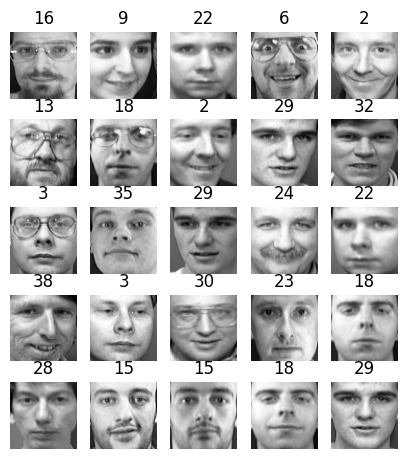

In [5]:
# Definir función para visualizar caras
def plot_faces(faces, labels, n_cols=5):
    faces = faces.values.reshape(-1, 64, 64)  # Convertir a matriz de 64x64
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

# Visualizar algunas caras del conjunto de entrenamiento
plot_faces(X_train.iloc[:25], y_train.iloc[:25])

### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [6]:
# Aplicar PCA para reducir la dimensionalidad al 99% de la varianza
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

# Mostrar el número de componentes principales obtenidos
print(f"Número de componentes principales: {pca.n_components_}")

Número de componentes principales: 220


### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

In [7]:
# Probar diferentes valores de K (de 5 a 150 con paso de 5)
k_values = range(5, 151, 5)
best_k = None
best_score = -1

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    labels = kmeans.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")
    
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nEl mejor K es {best_k} con un score de silueta de {best_score:.4f}")

K=5, Silhouette Score=0.1078
K=10, Silhouette Score=0.0805


C:\Users\aperez\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\aperez\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~

K=15, Silhouette Score=0.0861
K=20, Silhouette Score=0.1003
K=25, Silhouette Score=0.1128
K=30, Silhouette Score=0.1183
K=35, Silhouette Score=0.1234
K=40, Silhouette Score=0.1376
K=45, Silhouette Score=0.1534
K=50, Silhouette Score=0.1617
K=55, Silhouette Score=0.1610
K=60, Silhouette Score=0.1766
K=65, Silhouette Score=0.1815
K=70, Silhouette Score=0.1814
K=75, Silhouette Score=0.1861
K=80, Silhouette Score=0.1937
K=85, Silhouette Score=0.2035
K=90, Silhouette Score=0.2049
K=95, Silhouette Score=0.2001
K=100, Silhouette Score=0.1997
K=105, Silhouette Score=0.2042
K=110, Silhouette Score=0.2020
K=115, Silhouette Score=0.2065
K=120, Silhouette Score=0.2044
K=125, Silhouette Score=0.1992
K=130, Silhouette Score=0.1969
K=135, Silhouette Score=0.1988
K=140, Silhouette Score=0.1967
K=145, Silhouette Score=0.1963
K=150, Silhouette Score=0.1975

El mejor K es 115 con un score de silueta de 0.2065


### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

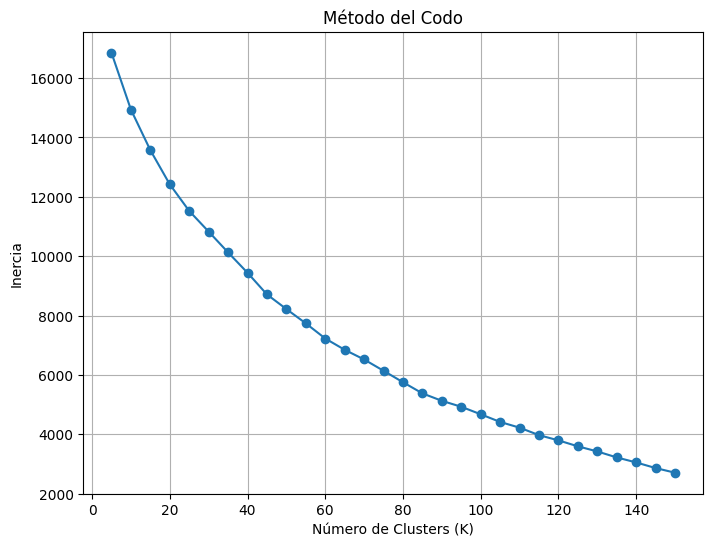

In [8]:
# Calcular la inercia para diferentes valores de K
k_values = range(5, 151, 5)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(X_train_pca)
    inertia_values.append(kmeans.inertia_)

# Graficar el gráfico del codo
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.grid()
plt.show()

# Buscar un "codo" visualmente o mediante una heurística

### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [20]:
# Calcular la segunda derivada
inertia_values = np.array(inertia_values)
second_derivative = np.diff(inertia_values, n=2)

# Encontrar el índice con la mayor curvatura (mínima segunda derivada)
elbow_idx = np.argmin(second_derivative) + 1  # +1 porque diff reduce el tamaño del array

# Obtener el valor óptimo de K
optimal_k = k_values[elbow_idx]

print(f'El número óptimo de clusters (K) es: {optimal_k}')

El número óptimo de clusters (K) es: 110


In [19]:
# Entrenar el modelo con el mejor K obtenido por el score de silueta
best_k = 110  # Supón que este es el mejor K
best_model = KMeans(n_clusters=best_k, random_state=seed)
best_model.fit(X_train_pca)

KMeans(n_clusters=110, random_state=22)

### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

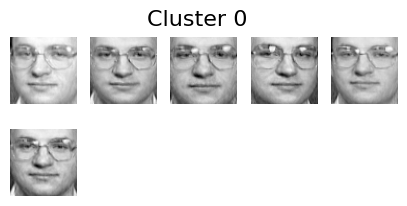

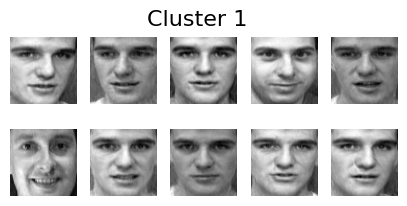

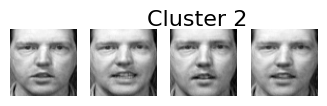

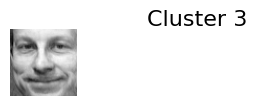

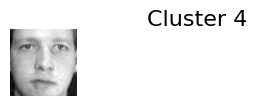

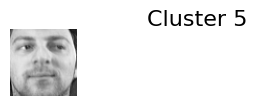

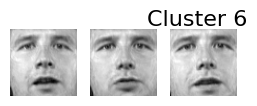

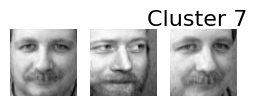

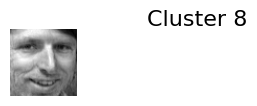

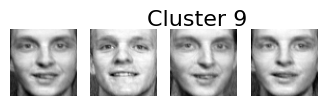

In [21]:
# Obtener las etiquetas de los clusters asignados por best_model
labels = best_model.labels_

# Reconstruir las imágenes originales desde las componentes principales
X_train_reconstructed = pca.inverse_transform(X_train_pca)

# Crear una función para visualizar caras por cluster
def plot_cluster_faces(cluster_id, X_reconstructed, labels, n_cols=5):
    cluster_indices = np.where(labels == cluster_id)[0]
    if len(cluster_indices) == 0:
        print(f"No hay muestras en el cluster {cluster_id}")
        return
    
    cluster_faces = X_reconstructed[cluster_indices]
    cluster_faces = cluster_faces.reshape(-1, 64, 64)
    n_rows = (len(cluster_faces) - 1) // n_cols + 1
    
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, face in enumerate(cluster_faces[:n_cols * n_rows]):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Cluster {cluster_id}", fontsize=16)
    plt.show()

# Visualizar los primeros 10 clusters
for i in range(10):
    plot_cluster_faces(i, X_train_reconstructed, labels)

## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [23]:
# Entrenar un RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
rf_clf.fit(X_train, y_train)

# Predecir en el conjunto de validación
y_valid_pred = rf_clf.predict(X_valid)

# Calcular la precisión
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Precisión del RandomForest en el conjunto de validación: {accuracy:.4f}")

Precisión del RandomForest en el conjunto de validación: 0.9500


### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [24]:
# Transformar los datos usando las distancias a los centroides
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

# Entrenar un RandomForest en los datos reducidos
rf_clf_reduced = RandomForestClassifier(n_estimators=150, random_state=42)
rf_clf_reduced.fit(X_train_reduced, y_train)

# Predecir en el conjunto de validación
y_valid_pred_reduced = rf_clf_reduced.predict(X_valid_reduced)

# Calcular la precisión
accuracy_reduced = accuracy_score(y_valid, y_valid_pred_reduced)
print(f"Precisión del RandomForest en datos reducidos: {accuracy_reduced:.4f}")

Precisión del RandomForest en datos reducidos: 0.8750


### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)

In [25]:
# Definir rangos de k a probar
k_values = range(5, 101, 5)
best_k = None
best_accuracy = 0

# Iterar sobre diferentes valores de k
for k in k_values:
    print(f"Probando k={k}...")
    
    # Entrenar K-Means con el valor actual de k
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    
    # Transformar los datos usando las distancias a los centroides
    X_train_reduced = kmeans.transform(X_train_pca)
    X_valid_reduced = kmeans.transform(X_valid_pca)
    
    # Entrenar un RandomForest con las nuevas características
    rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
    rf_clf.fit(X_train_reduced, y_train)
    
    # Evaluar en el conjunto de validación
    y_valid_pred = rf_clf.predict(X_valid_reduced)
    accuracy = accuracy_score(y_valid, y_valid_pred)
    
    print(f"Accuracy para k={k}: {accuracy:.4f}")
    
    # Actualizar el mejor k si encontramos una precisión mayor
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

# Resultados finales
print(f"\nEl mejor k encontrado es {best_k} con una precisión de {best_accuracy:.4f}")

Probando k=5...
Accuracy para k=5: 0.4000
Probando k=10...
Accuracy para k=10: 0.4250
Probando k=15...
Accuracy para k=15: 0.6750
Probando k=20...
Accuracy para k=20: 0.7000
Probando k=25...
Accuracy para k=25: 0.9500
Probando k=30...
Accuracy para k=30: 0.9000
Probando k=35...
Accuracy para k=35: 0.8500
Probando k=40...
Accuracy para k=40: 0.9000
Probando k=45...
Accuracy para k=45: 0.8250
Probando k=50...
Accuracy para k=50: 0.8500
Probando k=55...
Accuracy para k=55: 0.8250
Probando k=60...
Accuracy para k=60: 0.8750
Probando k=65...
Accuracy para k=65: 0.8500
Probando k=70...
Accuracy para k=70: 0.8750
Probando k=75...
Accuracy para k=75: 0.8750
Probando k=80...
Accuracy para k=80: 0.8750
Probando k=85...
Accuracy para k=85: 0.9250
Probando k=90...
Accuracy para k=90: 0.8750
Probando k=95...
Accuracy para k=95: 0.8750
Probando k=100...
Accuracy para k=100: 0.9250

El mejor k encontrado es 25 con una precisión de 0.9500
